## Part 1: Predicting molecular properties with Graph Convolutional Nets 

### 1.1 (5 points) Install and try out RDkit

This is a hack to install RDKit, without needing to install conda (which might take minutes). If you have anaconda installed, you can install RDKit from anaconda.

In [ ]:
url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
!curl -L $url | tar xj lib
!mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.7/dist-packages/

x86 = '/usr/lib/x86_64-linux-gnu'
!mv lib/*.so.* $x86/
!ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3729    0  3729    0     0   6225      0 --:--:-- --:--:-- --:--:--  6225
100 20.2M  100 20.2M    0     0  3221k      0  0:00:06  0:00:06 --:--:-- 3595k


In [ ]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import sys
import torch 
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*') # turn off RDKit warning message 

Optional: mount your Google Drive to save your model and files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
mydrive = '/content/drive/MyDrive'

Mounted at /content/drive


Example: make a Mol object.

In [ ]:
dopamine_mol = Chem.MolFromSmiles("C1=CC(=C(C=C1CCN)O)O") # Dopamine 
caffeine_mol = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C") # Caffeine 

Arrange molecules in a grid image.

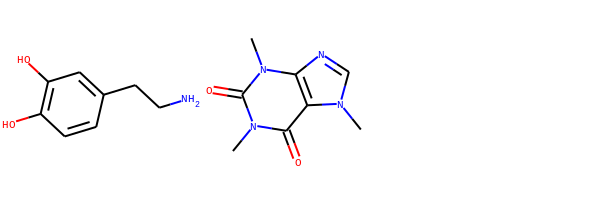

In [ ]:
# Arrange molecules in a grid image
Draw.MolsToGridImage([dopamine_mol, caffeine_mol])

Use RDKit to visualize molecule line drawings

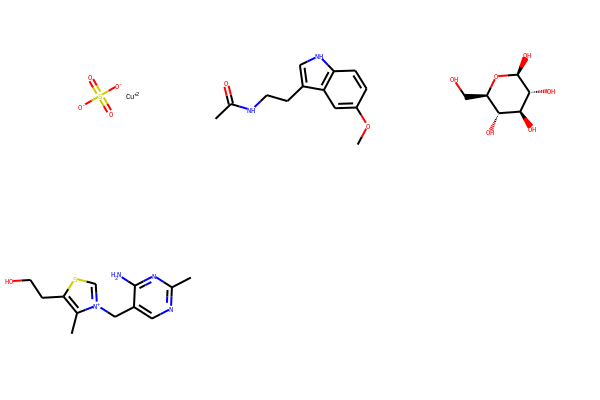

In [ ]:
################ Code #################

copper_sulfate = Chem.MolFromSmiles("[Cu+2].[O-]S(=O)(=O)[O-]")
melatonin = Chem.MolFromSmiles("CC(=O)NCCC1=CNc2c1cc(OC)cc2")
glucose = Chem.MolFromSmiles("OC[C@@H](O1)[C@@H](O)[C@H](O)[C@@H](O)[C@H](O)1") 
thiamine = Chem.MolFromSmiles("OCCc1c(C)[n+](cs1)Cc2cnc(C)nc2N") 

Draw.MolsToGridImage([copper_sulfate, melatonin, glucose, thiamine])


### 1.2 (10 points) Construct Molecular Graph Datasets and DataLoaders

In [ ]:
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/data/qm9.csv

--2022-04-08 18:00:07--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/data/qm9.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30584525 (29M) [text/plain]
Saving to: ‘qm9.csv’

qm9.csv             100%[===================>]  29.17M  --.-KB/s    in 0.1s    

2022-04-08 18:00:08 (249 MB/s) - ‘qm9.csv’ saved [30584525/30584525]



A SMILES to graph conversion function.

In [ ]:
def smiles2graph(smiles):
    '''
    Transform smiles into a list of atomic numbers and an edge array
    
    Args: 
        smiles (str): SMILES strings
    
    Returns: 
        z(np.array), A (np.array): list of atomic numbers, edge array
    '''
    
    mol = Chem.MolFromSmiles( smiles ) # no hydrogen 
    z = np.array( [atom.GetAtomicNum() for atom in mol.GetAtoms()] )
    A = np.stack(Chem.GetAdjacencyMatrix(mol)).nonzero()
    
    return z, A

Read in the DataFrame, shuffle its rows, and store its properties as lists.

In [ ]:
import torch
from sklearn.utils import shuffle

df = pd.read_csv("qm9.csv")
df = shuffle(df).reset_index()

################ Code #################

AtomicNum_list = []
Edge_list = []
y_list = []
Natom_list = []

for index, row in df.iterrows():
  z, A = smiles2graph(row['smiles'])
  AtomicNum_list.append(torch.LongTensor(z))
  Edge_list.append(torch.LongTensor(A))
  Natom_list.append(len(z))
  y_list.append(torch.FloatTensor([row['alpha']]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


A GraphDataset class for you to store graphs in PyTorch.

In [ ]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self,
                 AtomicNum_list, 
                 Edge_list, 
                 Natom_list, 
                 y_list):
        
        '''
        GraphDataset object
        
        Args: 
            z_list (list of torch.LongTensor)
            a_list (list of torch.LongTensor)
            N_list (list of int)
            y_list (list of torch.FloatTensor)

        '''
        self.AtomicNum_list = AtomicNum_list # atomic number
        self.Edge_list = Edge_list # edge list 
        self.Natom_list = Natom_list # Number of atoms 
        self.y_list = y_list # properties to predict 

    def __len__(self):
        return len(self.Natom_list)

    def __getitem__(self, idx):
        
        AtomicNum = torch.LongTensor(self.AtomicNum_list[idx])
        Edge = torch.LongTensor(self.Edge_list[idx])
        Natom = self.Natom_list[idx]
        y = torch.Tensor(self.y_list[idx])
        
        return AtomicNum, Edge, Natom, y

Split your dataset into train, validation, and test and define the GraphDataset class for each.

In [ ]:
################ Code #################
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

AtomicNum_train, AtomicNum_test, Edge_train, Edge_test, Natom_train, Natom_test, y_train, y_test = train_test_split(AtomicNum_list, Edge_list, Natom_list, y_list, test_size=0.2)
AtomicNum_train, AtomicNum_val, Edge_train, Edge_val, Natom_train, Natom_val, y_train, y_val = train_test_split(AtomicNum_train, Edge_train, Natom_train, y_train, test_size=0.1)


train_dataset = GraphDataset(AtomicNum_train, Edge_train, Natom_train, y_train)
val_dataset = GraphDataset(AtomicNum_val, Edge_val, Natom_val, y_val)
test_dataset = GraphDataset(AtomicNum_test, Edge_test, Natom_test, y_test)

A graph collation function to batch multiple graphs into one batch.

In [ ]:
def collate_graphs(batch):
    '''Batch multiple graphs into one batched graph
    
    Args:
    
        batch (tuple): tuples of AtomicNum, Edge, Natom and y obtained from GraphDataset.__getitem__() 
        
    Return 
        (tuple): Batched AtomicNum, Edge, Natom, y
    
    '''
    
    AtomicNum_batch = []
    Edge_batch = []
    Natom_batch = []
    y_batch = []

    cumulative_atoms = np.cumsum([0] + [b[2] for b in batch])[:-1]
    
    for i in range(len(batch)):
        z, a, N, y = batch[i]
        index_shift = cumulative_atoms[i]
        a = a + index_shift
        AtomicNum_batch.append(z) 
        Edge_batch.append(a)
        Natom_batch.append(N)
        y_batch.append(y)
        
    AtomicNum_batch = torch.cat(AtomicNum_batch)
    Edge_batch = torch.cat(Edge_batch, dim=1)
    Natom_batch = Natom_batch
    y_batch = torch.cat(y_batch)
    
    return AtomicNum_batch, Edge_batch, Natom_batch, y_batch 

An example use of collate_graph.

In [ ]:
# Define graph 1 
AtomicNum1 = torch.LongTensor([6, 6, 7])
Edge1 = torch.LongTensor([[0, 2, 2, 1], 
                       [2, 0, 1, 2]])
Natom1 = 3
y1 =  torch.Tensor([74.18])

# Define graph 2 
AtomicNum2 = torch.LongTensor([6, 6, 8])
Edge2 = torch.LongTensor([[0, 2, 2, 1], 
                       [2, 0, 1, 2]])
Natom2 = 3
y2 = torch.Tensor([64.32])

graph1 = (AtomicNum1, Edge1, Natom1, y1)
graph2 = (AtomicNum2, Edge2, Natom2, y2)

collate_graphs((graph1, graph2))  

(tensor([6, 6, 7, 6, 6, 8]), tensor([[0, 2, 2, 1, 3, 5, 5, 4],
         [2, 0, 1, 2, 5, 3, 4, 5]]), [3, 3], tensor([74.1800, 64.3200]))

Defining the train and test DataLoaders with the above functions.

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,
                          batch_size=512, 
                          collate_fn=collate_graphs,shuffle=True)

val_loader = DataLoader(val_dataset,
                          batch_size=512, 
                          collate_fn=collate_graphs,shuffle=True)

test_loader = DataLoader(test_dataset,
                          batch_size=512, 
                          collate_fn=collate_graphs,shuffle=True)

### 1.3 (20 points) Complete the definition of a GNN

The scatter_add function for use in your node updates.

In [ ]:
from itertools import repeat
def scatter_add(src, index, dim_size, dim=-1, fill_value=0):
    
    '''
    Sums all values from the src tensor into out at the indices specified in the index 
    tensor along a given axis dim. 
    '''
    
    index_size = list(repeat(1, src.dim()))
    index_size[dim] = src.size(dim)
    index = index.view(index_size).expand_as(src)
    
    dim = range(src.dim())[dim]
    out_size = list(src.size())
    out_size[dim] = dim_size

    out = src.new_full(out_size, fill_value)

    return out.scatter_add_(dim, index, src)

Example usage of scatter_add().

In [ ]:
# Say you have a graph with 4 nodes, and there are an edge list that describes their connectivities.

Edge = torch.LongTensor([[0, 0, 1, 3], # index for i 
                         [1, 2, 2, 0]]) # index for j 

# It means that the 0th node is connected to 1st node and the 2nd node; the 1st node is connected to the 2nd node. 
# For now, let us assume the connections are directed, i.e. 0th node is connected the 1st node, but the 1st node is not connected to the 0th node. 
# We want pass connection messages from the nodes in the first row to the nodes in the second row in Edge.

# And for each edge, we have an message we wanto broadcast from i to j.
message_i2j = torch.Tensor([1000., 100., 10., 1.])

# We can use scatter_add() function to aggregate these pairwise messages onto each node. 

node_message = scatter_add(src=message_i2j, # message array for all the directed edge 
            index=Edge[1], # index to all the jth node to which you want to pass your message 
            dim=0,         # feature dimension you want to sum over 
            dim_size=4     # there are 4 nodes 
            ) 

print(node_message)

# Now you can look at your results, you can see the messages are assigned from message_i2j to all the jth nodes you specified

# see the graphical representation here: "https://github.com/vikram-sundar/ML4MolEng_Spring2022/blob/master/psets/ps4/scatter_add_demo.png"

tensor([   1., 1000.,  110.,    0.])


In [ ]:
# If you want your graph to be undirected, i.e. the ith node is connected to the jth node and vice versa, you can perfrom the summation in both direction like this: 
node_message = scatter_add(src=message_i2j, index=Edge[1], dim=0, dim_size=4) +  scatter_add(src=message_i2j, index=Edge[0], dim=0, dim_size=4)

print(node_message)

tensor([1.1010e+03, 1.0100e+03, 1.1000e+02, 1.0000e+00])


Example usage of torch.split().

In [ ]:
splits_idx = [2, 3] # list of integers 
print( torch.split(torch.Tensor([1000., 100., 10., 1., 5.]), splits_idx) ) 

# you have two tensors with size (2,2) and (3,2) respectively 
for split in torch.split(torch.Tensor([1000., 100., 10., 1., 5.]), splits_idx):
    print(split.shape)
    
# And you can sum the spllited array separately and stack them together 
print( torch.stack([split.sum(0) for split in torch.split(torch.Tensor([1000., 100., 10., 1., 5.]), splits_idx)], dim=0) )

(tensor([1000.,  100.]), tensor([10.,  1.,  5.]))
torch.Size([2])
torch.Size([3])
tensor([1100.,   16.])


Your GNN class.


In [ ]:
from torch import nn
from torch.nn import ModuleDict

class GNN(torch.nn.Module):
    '''
        A GNN model 
    '''
    def __init__(self, n_convs=3, n_embed=64):
        super(GNN, self).__init__()
        
        self.atom_embed = nn.Embedding(100, n_embed)
        # Declare MLPs in a ModuleList
        self.convolutions = nn.ModuleList(
            [ 
                ModuleDict({
                    'update_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                nn.ReLU(), 
                                                nn.Linear(n_embed, n_embed)),
                    'message_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                 nn.ReLU(), 
                                                 nn.Linear(n_embed, n_embed)) 
                })
                for _ in range(n_convs)
            ]
            )
        # Declare readout layers
        self.readout = nn.Sequential(nn.Linear(n_embed, n_embed), nn.ReLU(), nn.Linear(n_embed, 1))
        
    def forward(self, AtomicNum, Edge, Natom):
        ################ Code #################
        
        # Parametrize embedding 
        h = self.atom_embed(AtomicNum) #eqn. 1
        
        for convolution in self.convolutions:
          m = convolution['message_mlp'](h[Edge[0]]*h[Edge[1]])
          m = scatter_add(src=m,
                          index=Edge[1], 
                          dim=0,
                          dim_size=h.shape[0])

          h += convolution['update_mlp'](m)

        output = self.readout(h)          
        output = torch.stack([torch.sum(split) for split in torch.split(output, Natom)], dim=0)
        
        ################ Code #################
        return output

### 1.4 (5 points) Verify that your GNN preserves permutational invariance

Run this cell as is to show that your GNN respects permutational invariance.

In [ ]:
def permute_graph(z, a, perm):
    '''
        permute the order of nodes in a molecular graph 
        
        Args: 
            z(np.array): atomic number array
            a(np.array): edge index pairs 
            
        Return: 
            (np.array, np.array): permuted atomic number, and edge list 
    '''
    
    z = np.array(z)
    perm = np.array(perm)
    assert len(perm) == len(z)
    
    z_perm = z[perm]
    a_perm = np.zeros(a.shape).astype(int)
    
    for i, edge in enumerate(a):
        for j in range(len(edge)):
            a_perm[i, j] = np.where(perm==edge[j])[0]
    return z_perm, a_perm

# node input
z_orig = np.array([6, 6, 8, 7])
# edge input 
a_orig = np.array([[0, 0, 1, 2, 3, 0], [1, 2, 0, 0, 0, 3]] )

permutation = itertools.permutations([0, 1 ,2, 3])
device = 'cuda:0'
model = GNN(n_convs=4, n_embed=128).to(device)
model.eval()

for perm in permutation:
    z_perm, a_perm = permute_graph(z_orig, a_orig, perm)
    
    z = torch.LongTensor(z_perm).to(device)
    a = torch.LongTensor(a_perm).to(device)
    N = [z.shape[0]]

    output = model(z, a, N).item()
    
    print("model output: {:.5f} for perumutation: {}".format(output, perm)) 

model output: 1.21122 for perumutation: (0, 1, 2, 3)
model output: 1.21122 for perumutation: (0, 1, 3, 2)
model output: 1.21122 for perumutation: (0, 2, 1, 3)
model output: 1.21122 for perumutation: (0, 2, 3, 1)
model output: 1.21122 for perumutation: (0, 3, 1, 2)
model output: 1.21122 for perumutation: (0, 3, 2, 1)
model output: 1.21122 for perumutation: (1, 0, 2, 3)
model output: 1.21122 for perumutation: (1, 0, 3, 2)
model output: 1.21122 for perumutation: (1, 2, 0, 3)
model output: 1.21122 for perumutation: (1, 2, 3, 0)
model output: 1.21122 for perumutation: (1, 3, 0, 2)
model output: 1.21122 for perumutation: (1, 3, 2, 0)
model output: 1.21122 for perumutation: (2, 0, 1, 3)
model output: 1.21122 for perumutation: (2, 0, 3, 1)
model output: 1.21122 for perumutation: (2, 1, 0, 3)
model output: 1.21122 for perumutation: (2, 1, 3, 0)
model output: 1.21122 for perumutation: (2, 3, 0, 1)
model output: 1.21122 for perumutation: (2, 3, 1, 0)
model output: 1.21122 for perumutation: (3, 0,

### 1.5  (10 points) Train and test your GNN

The optimizer and scheduler setup.

In [ ]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

A combined train/validation loop, with progress bar.

In [ ]:
def loop(model, loader, epoch, evaluation=False):
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
    
    # Define tqdm progress bar 
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    
    for data in tqdm_data:
        
        AtomicNumber, Edge, Natom, y = data 
        AtomicNumber = AtomicNumber.to(device)
        Edge = Edge.to(device)
        y = y.to(device)
        pred = model(AtomicNumber, Edge, Natom)
        loss = (pred-y).pow(2).mean() # MSE loss
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['batch loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

Run this cell to train your model for 500 epochs.

In [ ]:
# RELOADED MODEL FOR TRAINING FOR FINAL 20 EPOCHS
mydict = torch.load(f'{mydrive}/gcn_model_480.pt')
model = GNN(n_convs=4, n_embed=128)
model.load_state_dict(mydict)
model.cuda()

for epoch in range(20):    
    train_loss = loop(model, train_loader, epoch)
    val_loss = loop(model, val_loader, epoch, evaluation=True)
    
    # save model 
    if epoch % 20 == 0:
        torch.save(model.state_dict(), "{}/gcn_model_{}.pt".format(mydrive, epoch))

torch.save(model.state_dict(), "{}/gcn_model_final.pt".format(mydrive))

eval (epoch #19): 100%|██████████| 21/21 [00:00<00:00, 26.49it/s, batch loss=2.547 avg. loss=2.897]


Show us a scatter plot of the training and test data, with MSEs labeled.

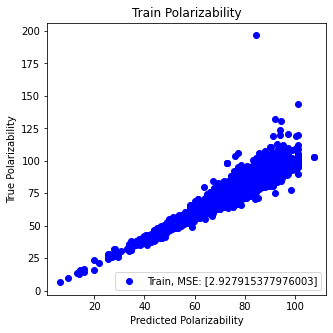

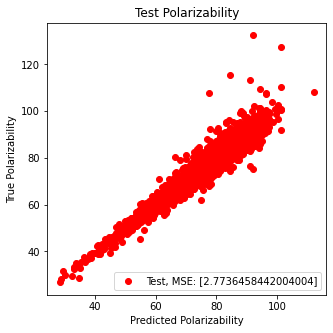

In [ ]:
################ Code #################
from statistics import mean

device = 'cuda:0'
mydict = torch.load(f'{mydrive}/gcn_model_final.pt')
model = GNN(n_convs=4, n_embed=128)
model.load_state_dict(mydict)
model.cuda()

torch.cuda.empty_cache()
model.eval()

loaders = {"Train": train_loader, "Test": test_loader}
color = {"Train": "blue", "Test": "red"}

for name, loader in loaders.items():
  loss = []
  all_pred = []
  all_y = []

  for i, data in enumerate(loader):
    AtomicNumber, Edge, Natom, y = data 
    AtomicNumber = AtomicNumber.to(device)
    Edge = Edge.to(device)
    y = y.to(device)
    pred = model(AtomicNumber, Edge, Natom)

    all_pred += pred.detach().cpu().numpy().tolist()
    all_y += y.detach().cpu().numpy().tolist()
  
  loss.append(mean(np.square(np.array(all_pred)-np.array(all_y)))) # MSE loss

  fig, ax = plt.subplots(figsize=(5,5))
  ax.scatter(all_pred, all_y, color=color[name], label=f"{name}, MSE: {loss}") 
  plt.xlabel('Predicted Polarizability')
  plt.ylabel('True Polarizability')
  plt.title(f"{name} Polarizability")
  ax.legend()

## Part 2: Variational auto-encoders for SMILES strings

In [ ]:
# Get data 
! wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/data/zinc_50k.csv
    
# Get pretrained model
! wget -O vae_checkpoint.pth https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/pretrained_checkpoints/vae-050-0.06.pth

--2022-04-07 12:57:35--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/data/zinc_50k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2504809 (2.4M) [text/plain]
Saving to: ‘zinc_50k.csv’

zinc_50k.csv        100%[===================>]   2.39M  --.-KB/s    in 0.04s   

2022-04-07 12:57:35 (56.4 MB/s) - ‘zinc_50k.csv’ saved [2504809/2504809]

--2022-04-07 12:57:35--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps4/pretrained_checkpoints/vae-050-0.06.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP 

### 2.1 (5 points) One-hot encode SMILES strings into padded numerical vectors

In [ ]:
from sklearn import preprocessing

# Character list for SMILES string
moses_charset = ['2', 'o', 'C', 'I', 'O', 'H', 'n', 'N', '=', '+', '#', '-', 'c',
                 'B', 'l', '7', 'r', 'S', 's', '4', '6', '[', '5', ']', 'F', '3', 
                 'P', '(', ')', '1', ' ']

# Define encoder 
enc = preprocessing.LabelEncoder().fit(moses_charset)

# Read data 
df = pd.read_csv("./zinc_50k.csv")


Encode SMILES strings into padded categorical vectors.

In [ ]:
################ Code #################
smiles = [smile for smile in df['SMILES']]

# add padding
max_len = max([len(x) for x in smiles])
smiles = [smile + " "*(max_len-len(smile)) for smile in smiles]

# encoding
encoded = []
for smile in smiles:
  temp_encoded = []
  for letter in smile:
    temp_encoded.extend(enc.transform([letter]))
  encoded.append(torch.LongTensor(temp_encoded))


Make train/validation/test Datasets and DataLoaders.

In [ ]:
################ Code #################

# Train, validation, test split
train, test = train_test_split(encoded, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)

# Build DataLoader 
batch_size = 512
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

### 2.2 (14 points) Implement the Reparametrization Trick for VAE

In [ ]:
# Molecular VAE model 

class MolVAE(nn.Module):
    def __init__(self,  rnn_enc_hid_dim, enc_nconv,
                         encoder_hid, z_dim, 
                         rnn_dec_hid_dim, dec_nconv, smiles_len, nchar
                         ):
        '''
            SMILES VAE model 
            
                rnn_enc_hid_dim: hidden dimension for the GRU encoder 
                enc_nconv: number of recurrent layers for the GRU decoder
                encoder_hid: dimension of GUR encoder readout
                z_dim: number of latent variable 
                rnn_dec_hid_dim: hidden dimension for the GRU decoder 
                dec_nconv: number of recurrent layers for the GRU decoder
                smiles_len: total length of padded SMILES string 
                nchar: number of possible characters 
                
        '''
        
        super(MolVAE, self).__init__()
        
        self.smiles_len = smiles_len
        self.nchar = nchar
        # Embedding layer
        self.embed = nn.Embedding(self.nchar, rnn_enc_hid_dim)
        # Encoding GRU
        self.rnn_enc = nn.GRU(rnn_enc_hid_dim, rnn_enc_hid_dim, enc_nconv, batch_first=True)
        # MLP to transfrom hidden output from Encoding GRU
        self.mlp0 = nn.Linear(rnn_enc_hid_dim, encoder_hid)
        # Network to parametrize mu
        self.mu_network = nn.Linear(encoder_hid, z_dim)
        # Network to parametrize log variance
        self.logvar_network = nn.Linear(encoder_hid, z_dim)
        # Decoding GRU
        self.rnn_dec = nn.GRU(z_dim, rnn_dec_hid_dim, dec_nconv, batch_first=True)
        # Output SMILES characters
        self.readout = nn.Linear(rnn_dec_hid_dim, self.nchar)

    def encode(self, x):
        '''Output mean and log variance of the encoded SMILES'''
        output, hn = self.rnn_enc(x)
        h = torch.nn.functional.relu(self.mlp0(hn[-1]))
        return self.mu_network(h), self.logvar_network(h)
    
    def get_std(self, logvar):
        '''Transform log variance to standard deviation'''
        ################ Code #################
        return (0.5*logvar).exp()
        ################ Code #################

    def reparametrize(self, mu, std):
        '''The reparametrization trick'''
        if self.training:
            ################ Code #################
            z = mu + torch.randn_like(std) * std
            return z
           ################ Code ################# 
        else:
            return mu

    def decode(self, z):
        '''Decoder to reconstruct latent variable back to SMILES'''
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.smiles_len, 1)
        out, h = self.rnn_dec(z)
        out_reshape = out.contiguous().view(-1, out.size(-1))
        
        y0 = self.readout(out_reshape)
        y = y0.contiguous().view(out.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        x_embed = self.embed(x) # Get SMILES embedding 
        mu, logvar = self.encode(x_embed) # Encoding SMILES to latent representations 
        std = self.get_std(logvar) # Transform log variance to std.
        z = self.reparametrize(mu, std) # Reparametrization trick 
        smiles_recon = self.decode(z)  # Reconstruct SMILES string 
        return smiles_recon, mu, std

Test your model by comparing your sampling with N(0, 1).

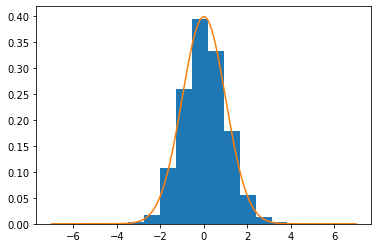

In [ ]:
# Define your model 
model = MolVAE(rnn_enc_hid_dim=256, enc_nconv=1, 
                     encoder_hid=256, z_dim=128, rnn_dec_hid_dim=512,
                    dec_nconv=3, nchar=31, smiles_len=max_len)

# Compare your sampling with N(0, 1)

import matplotlib.pyplot as plt
from scipy.stats import norm

sample = model.reparametrize(torch.zeros(1000), torch.ones(1000))
plt.hist(sample.detach().cpu().numpy(), density=True)

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-7, 7, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1)) # Mean = 0, SD = 1.
plt.show()


### 2.3 (14 points) Implement the SMILES VAE loss function

Implement your loss function here.

In [ ]:
def loss_function(recon_x, x, mu, std):
    ################ Code #################
    L_recon = 0.0  # reconstruction loss 
    L_kl = 0.0 # KL loss

    recon_x = torch.permute(recon_x, (0, 2, 1)).to(device)
    x = x.to(device)

    L_recon = torch.nn.functional.cross_entropy(recon_x, x)

    Nbatch = len(recon_x)
    logvar = 2 * std.log()
    L_kl = torch.sum(0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)) / Nbatch

    return L_recon, L_kl

### 2.4 (2 points) Train your model

Run the following cells to train your model.

In [ ]:


def loop(model, loader, epoch, beta=0.05, evaluation=False):
    '''
        Train/test your VAE model
    '''
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
        
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    for data in tqdm_data:
        x = data.to(device)
        recon_batch, mu, std = model(x)

        loss_recon, loss_kl = loss_function(recon_batch, x, mu, std)
        loss = loss_recon + beta * loss_kl     
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['recon loss={:.3f}'.format(loss_recon.item()) ,
                   'KL loss={:.3f}'.format(loss_kl.item()) ,
                   'total loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

In [ ]:
device = 0

model = MolVAE(rnn_enc_hid_dim=367, enc_nconv=2, 
                     encoder_hid=512, z_dim=171, rnn_dec_hid_dim=512,
                    dec_nconv=1, nchar=31, smiles_len=max_len)
                      
model = model.to(device)

# load pretrained model 
model.load_state_dict(torch.load("./vae_checkpoint.pth"))

<All keys matched successfully>

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=5e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

In [ ]:
epochs = 50

for epoch in range(0, epochs):
    
    train_loss = loop(model, train_loader, epoch, 0.001)
    val_loss = loop(model, val_loader, epoch, 0.001,  evaluation=True)
    scheduler.step(val_loss)
    
    # optional: save model 
    if epoch % 15 == 0:
       torch.save(model.state_dict(), '{}/vae-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))
       torch.save(optimizer.state_dict(), '{}/optim-{:03d}-{:.2f}.pth'.format(mydrive, epoch, train_loss))
    
    if epoch == 0:
        best_loss = train_loss.item()
    else:
        if train_loss.item() < best_loss:
            best_loss = train_loss.item()

torch.save(model.state_dict(), '{}/vae-final.pth'.format(mydrive))
torch.save(optimizer.state_dict(), '{}/optim-final.pth'.format(mydrive))

eval (epoch #32): 100%|██████████| 20/20 [00:00<00:00, 32.26it/s, recon loss=0.021 KL loss=109.211 total loss=0.130 avg. loss=0.133]


Epoch    34: reducing learning rate of group 0 to 2.5000e-05.


eval (epoch #41): 100%|██████████| 20/20 [00:00<00:00, 31.55it/s, recon loss=0.024 KL loss=108.520 total loss=0.133 avg. loss=0.133]


Epoch    43: reducing learning rate of group 0 to 1.2500e-05.


eval (epoch #49): 100%|██████████| 20/20 [00:00<00:00, 31.75it/s, recon loss=0.020 KL loss=107.952 total loss=0.128 avg. loss=0.132]


### 2.5 (10 points) Sample new molecules

Some helper functions for you.

In [ ]:
def index2smiles(mol_index, enc):
    '''Transform your array of character indices back to SMILES'''
    smiles_charlist = enc.inverse_transform(np.array(mol_index))
    smiles = ''.join(smiles_charlist).strip(" ")
    
    return smiles

def check_smiles_valid(smiles):
    '''Check if SMILES string is valid'''
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        valid = True 
    else:
        valid = False 
    return valid

Randomly select two SMILES in your test data, interpolate 10 points between them, and decode those points. Test them for accuracy and draw the scatter plot of the lower 2 dimensions. Then visualize any molecules that worked.

In [ ]:
################ Code #################
# select a starting and ending molecule
import random
start_enc = test_loader.dataset.__getitem__((random.choices(range(len(test_loader.dataset)), k=1))[0]).numpy().reshape(-1)
end_enc = test_loader.dataset.__getitem__((random.choices(range(len(test_loader.dataset)), k=1))[0]).numpy().reshape(-1)
start = index2smiles(start_enc, enc)
end = index2smiles(end_enc, enc)

model.eval()
start = torch.LongTensor([start_enc]).to(device)
smiles1_recon, mu1, std1 = model(start)


end = torch.LongTensor([end_enc]).to(device)
smiles2_recon, mu2, std2 = model(end)


valid_new = []
molecules = {}
softmax = torch.nn.Softmax(dim=2)
for i in range(1, 11):
  generated = (mu1 + i/11 * (mu2 - mu1))
  generated = model.decode(generated)
  generated = np.argmax(softmax(generated).cpu().detach().numpy(), axis=2).squeeze()
  generated_smile = index2smiles(generated, enc)

  gen = torch.LongTensor([generated]).to(device)
  smiles_recon, mu, std = model(gen)
  z = model.reparametrize(mu, std).squeeze().cpu().detach().numpy()

  molecules[generated_smile] = (z[0], z[1])

  if check_smiles_valid(generated_smile):
    valid_new.append(generated_smile)

There are 2 valid new SMILES: COC(=O)CC1CN(Cc2cc(Cl)ccc2F)CCO1, CC(C)CN(C)S(=O)(=O)c1cccc(C#N)c1


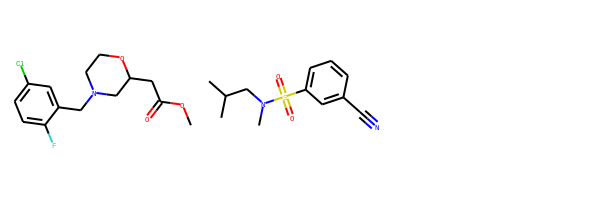

In [ ]:
print(f"There are {len(valid_new)} valid new SMILES: {', '.join(valid_new)}")

Draw.MolsToGridImage([Chem.MolFromSmiles(smile) for smile in valid_new])

In [ ]:
# TEST MOLECULES
test_z1 = []
test_z2 = []

for data in test_loader:
  x = data.to(device)
  for sequence in data:
    sequence = torch.unsqueeze(sequence, 0).to(device)
    recon_batch, mu, std = model(sequence)
    z = model.reparametrize(mu, std).squeeze().cpu().detach().numpy()

    test_z1.append(z[0])
    test_z2.append(z[1])

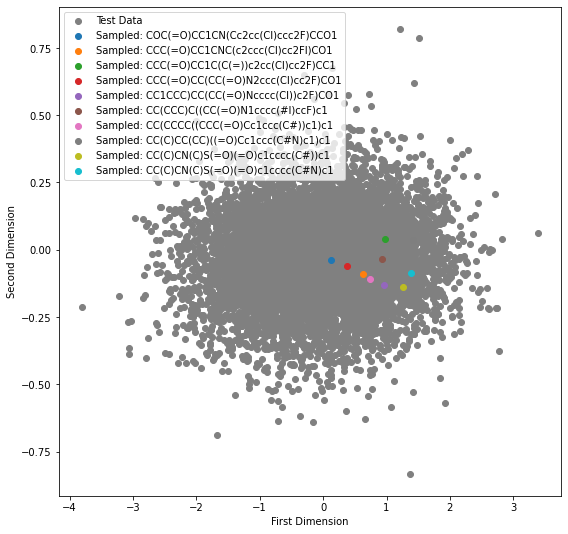

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(test_z1, test_z2, color="grey", label="Test Data")

for molecule, components in molecules.items():
  ax.scatter(components[0], components[1], label=f"Sampled: {molecule}") 

plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
ax.legend()

Why does the VAE sometimes fail to generate valid SMILES strings?

In [ ]:
'''
VAE adds small amounts of noise to the output, and since SMILES strings have rigid criteria to their
grammar/formation, even small amounts of additional noise can make the SMILE string invalid.
'''